In [1]:
import h5py
import numpy as np
from keras.layers import Layer

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dense, Reshape, Add

In [2]:
# load in training data (pre-pandemic)
with h5py.File('data/201911_dataset.h5', 'r') as f:    
    nov_traffic_data = f['trip'][()]
    nov_dates = f['timeslot'][()]

with h5py.File('data/201912_dataset.h5', 'r') as f:    
    dec_traffic_data = f['trip'][()]
    dec_dates = f['timeslot'][()]

with h5py.File('data/202001_dataset.h5', 'r') as f:
    jan_traffic_data = f['trip'][()]
    jan_dates = f['timeslot'][()]

with h5py.File('data/202002_dataset.h5', 'r') as f:
    feb_traffic_data = f['trip'][()]
    feb_dates = f['timeslot'][()]

# load in anomalous data (post-pandemic)
with h5py.File('data/202004_dataset.h5', 'r') as f:
    april_traffic_data = f['trip'][()]
    april_dates = f['timeslot'][()]

In [3]:
def featurize_traffic_data(traffic_data):
    # Set number of samples, considering 4 past intervals and 1 future interval for labels
    num_samples = traffic_data.shape[0] - 4 
    # Initialize feature array (samples, 16 rows, 8 cols, 4 time intervals)
    X = np.zeros((num_samples, 16, 8, 4)) 
    # Initialize label array (samples, 2, 16 rows, 8 cols)
    y = np.zeros((num_samples, 2, 16, 8)) 

    # Build feature and label datasets
    for i in range(num_samples):
        # Transpose feature data to fit model input shape
        X[i] = traffic_data[i:i+4, 0, :, :].transpose(1, 2, 0)
        # Set next interval data as labels
        y[i] = traffic_data[i+4] 

    return X, y

# Prepare data for model training
nov_X, nov_y = featurize_traffic_data(nov_traffic_data)
dec_X, dec_y = featurize_traffic_data(dec_traffic_data)
jan_X, jan_y = featurize_traffic_data(jan_traffic_data)
feb_X, feb_y = featurize_traffic_data(feb_traffic_data)
april_X, april_y = featurize_traffic_data(april_traffic_data)


In [4]:
def train_test_split(X, y, train_ratio = 0.8):
    # Calculate train set size based on specified ratio
    total_samples = len(X)
    train_size = int(total_samples * train_ratio)

    # Split the data into training and testing sets
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    return X_train, X_test, y_train, y_test

# Apply function to split data for different months
nov_X_train, nov_X_test, nov_y_train, nov_y_test = train_test_split(nov_X, nov_y)
dec_X_train, dec_X_test, dec_y_train, dec_y_test = train_test_split(dec_X, dec_y)
jan_X_train, jan_X_test, jan_y_train, jan_y_test = train_test_split(jan_X, jan_y) 
feb_X_train, feb_X_test, feb_y_train, feb_y_test = train_test_split(feb_X, feb_y)


In [5]:
# Define baseline CNN architecture
def baseline_model(input_shape, neurons, learning_rate, input_name):
    # Define the input layer
    input_layer = Input(shape=input_shape, name=input_name)

    # Add convolutional and pooling layers
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten and add dense layers
    flat = Flatten()(pool3)
    dense = Dense(neurons, activation='relu')(flat)
    output_layer = Dense(np.prod((2, 16, 8)), activation='relu')(dense)
    output_reshaped = Reshape((2, 16, 8))(output_layer)
    
    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_reshaped)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

In [7]:
# Prepare training data for different months
months_data = {
    'November': (nov_X_train, nov_y_train),
    'December': (dec_X_train, dec_y_train),
    'January': (jan_X_train, jan_y_train),
    'February': (feb_X_train, feb_y_train)
}

# Define the range of hyperparameters to test
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'neurons': [64, 128, 256],
    'batch_size': [16, 32, 64]
}

results = {}

# Iterate over each month's data
for month, (X_train, y_train) in months_data.items():
    # Set up the model using KerasRegressor with a lambda function for parameter flexibility
    model = KerasRegressor(build_fn=lambda neurons=128, learning_rate=0.001: baseline_model(input_shape=(16, 8, 4), neurons=neurons, learning_rate=learning_rate, input_name=f'{month.lower()}_input'), verbose=0, epochs=20, batch_size=32)
    # Initialize RandomizedSearchCV to tune hyperparameters
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=2, verbose=0, random_state=42, n_jobs=1)
    # Perform the search on the training data
    random_search.fit(X_train, y_train)
    # Capture the best score and parameters
    best_score = random_search.best_score_
    best_params = random_search.best_params_
    results[month] = (best_score, best_params)

# Output the best results for each month
for month, (best_score, best_params) in results.items():
    print(f"Best results for {month}: {best_score} using {best_params}")

Best results for November: -46.0427360534668 using {'neurons': 64, 'learning_rate': 0.01, 'batch_size': 32}
Best results for December: -32.92784595489502 using {'neurons': 128, 'learning_rate': 0.01, 'batch_size': 32}
Best results for January: -32.1389274597168 using {'neurons': 128, 'learning_rate': 0.01, 'batch_size': 32}
Best results for February: -32.74645805358887 using {'neurons': 128, 'learning_rate': 0.01, 'batch_size': 32}


In [6]:
# Configure and train the November model
nov_model = baseline_model(input_shape=(16, 8, 4), neurons=128, learning_rate=0.01, input_name='nov_input')
nov_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
nov_history = nov_model.fit(
    nov_X_train, 
    nov_y_train, 
    validation_data=(nov_X_test, nov_y_test), 
    epochs=50, 
    batch_size=32, 
    verbose=0,
    callbacks=[nov_early_stopping]
)

# Configure and train the December model
dec_model = baseline_model(input_shape=(16, 8, 4), neurons=128, learning_rate=0.01, input_name='dec_input')
dec_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
dec_history = dec_model.fit(
    dec_X_train, 
    dec_y_train, 
    validation_data=(dec_X_test, dec_y_test), 
    epochs=50, 
    batch_size=32, 
    verbose=0,
    callbacks=[dec_early_stopping]
)

# Configure and train the January model
jan_model = baseline_model(input_shape=(16, 8, 4), neurons=128, learning_rate=0.01, input_name='jan_input')
jan_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
jan_history = jan_model.fit(
    jan_X_train, 
    jan_y_train, 
    validation_data=(jan_X_test, jan_y_test), 
    epochs=50, 
    batch_size=32, 
    verbose=0,
    callbacks=[jan_early_stopping]
)

# Configure and train the February model
feb_model = baseline_model(input_shape=(16, 8, 4), neurons=128, learning_rate=0.01, input_name='feb_input')
feb_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
feb_history = feb_model.fit(
    feb_X_train, 
    feb_y_train, 
    validation_data=(feb_X_test, feb_y_test), 
    epochs=50, 
    batch_size=32, 
    verbose=0,
    callbacks=[feb_early_stopping]
)

In [7]:
#Save baseline model weights to be used in multi-input CNN
nov_model.save_weights('model_weights/nov_model_weights.h5')
dec_model.save_weights('model_weights/dec_model_weights.h5')
jan_model.save_weights('model_weights/jan_model_weights.h5')
feb_model.save_weights('model_weights/feb_model_weights.h5')

In [7]:
#split Anomalous April 2020 into train/val/test splits
split_index = len(april_X) // 2
april_X_train, april_X_test = april_X[:split_index], april_X[split_index:]
april_y_train, april_y_test = april_y[:split_index], april_y[split_index:]

split_index = int(len(april_X) * 0.8)
april_X_train, april_X_val = april_X_train[:split_index], april_X_train[split_index:]
april_y_train, april_y_val = april_y_train[:split_index], april_y_train[split_index:]

In [31]:
class iLayer(Layer):
    """
    Custom layer with per-element and global scaling weights.
    """

    def __init__(self, **kwargs):
        # Call to the parent class to handle standard initialization
        super(iLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create weights once input shape is known
        # Exclude batch size from input shape for weight dimensions
        initial_weight_value = np.random.random(input_shape[1:])
        self.W = self.add_weight(shape=input_shape[1:], initializer='random_normal', trainable=True)
        self.scaling_weight = self.add_weight(shape=(), initializer='ones', name='scaling_weight', trainable=True)

    def call(self, x):
        # Process input by applying weights and scaling
        return x * self.W * self.scaling_weight

    def compute_output_shape(self, input_shape):
        # Return input shape as output shape
        return input_shape

In [32]:
def integrated_model(input_shape):
    # Initialize branch models for November, December, January, and February
    nov_branch = baseline_model(input_shape, 128, 0.01, 'nov_input')
    dec_branch = baseline_model(input_shape, 128, 0.01, 'dec_input')
    jan_branch = baseline_model(input_shape, 128, 0.01, 'jan_input')
    feb_branch = baseline_model(input_shape, 128, 0.01, 'feb_input')

    # Load pre-trained weights into each branch
    nov_branch.load_weights('model_weights/nov_model_weights.h5')
    dec_branch.load_weights('model_weights/dec_model_weights.h5')
    jan_branch.load_weights('model_weights/jan_model_weights.h5')
    feb_branch.load_weights('model_weights/feb_model_weights.h5')

    # Process outputs of each branch through a custom scaling layer (iLayer) which applies per-element weights and a global scaling factor
    nov_output = iLayer(name='iLayer_nov')(nov_branch.layers[-3].output)
    dec_output = iLayer(name='iLayer_dec')(dec_branch.layers[-3].output)
    jan_output = iLayer(name='iLayer_jan')(jan_branch.layers[-3].output)
    feb_output = iLayer(name='iLayer_feb')(feb_branch.layers[-3].output)

    # Combine scaled outputs from all branches using an Add layer which performs a weighted sum of the month outputs
    added_output = Add(name='add_layer')([nov_output, dec_output, jan_output, feb_output])
    final_dense = Dense(128, activation='relu', name='final_dense')(added_output)
    final_output = Dense(np.prod((2, 16, 8)), activation='relu', name='final_output')(final_dense)
    final_output_reshaped = Reshape((2, 16, 8), name='output_reshape')(final_output)

    # Assemble and compile the final integrated model
    meta_model = Model(inputs=[nov_branch.input, dec_branch.input, jan_branch.input, feb_branch.input], outputs=final_output_reshaped)
    meta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return meta_model

# Instantiate the model
meta_model = integrated_model((16, 8, 4))

# Fit the model on training data and validate on testing data
meta_model.fit(
    [april_X_train, april_X_train, april_X_train, april_X_train], 
    april_y_train,
    validation_data=([april_X_val, april_X_val, april_X_val, april_X_val], april_y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)]
)

# Evaluate the model's performance on test data
test_loss, test_mae = meta_model.evaluate([april_X_test, april_X_test, april_X_test, april_X_test], april_y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

Epoch 1/50
23/23 [==============================] - 2s 19ms/step - loss: 459.5724 - mae: 10.4505
Epoch 2/50
23/23 [==============================] - 0s 11ms/step - loss: 195.3611 - mae: 6.4009
Epoch 3/50
23/23 [==============================] - 0s 12ms/step - loss: 149.1125 - mae: 5.2000
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: 135.6907 - mae: 4.9088
Epoch 5/50
23/23 [==============================] - 0s 10ms/step - loss: 122.3659 - mae: 4.6009
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 111.6788 - mae: 4.3404
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 106.9450 - mae: 4.2066
Epoch 8/50
23/23 [==============================] - 0s 10ms/step - loss: 101.3892 - mae: 4.0182
Epoch 9/50
23/23 [==============================] - 0s 10ms/step - loss: 97.2799 - mae: 3.8717
Epoch 10/50
23/23 [==============================] - 0s 10ms/step - loss: 94.4615 - mae: 3.7747
Epoch 11/50
23/23 [=====================

In [33]:
def print_layer_importances(model):
    month_names = ['November', 'December', 'January', 'February']
    # Directly access the layers used for each month
    layers_of_interest = [model.get_layer('iLayer_nov'), model.get_layer('iLayer_dec'),
                          model.get_layer('iLayer_jan'), model.get_layer('iLayer_feb')]

    for month, layer in zip(month_names, layers_of_interest):
        scaling_weight = layer.scaling_weight.numpy()  # Extract the numpy value of the scaling weight
        print(f'Importance of {month}: {scaling_weight}')

print_layer_importances(meta_model)


Importance of November: 1.0354055166244507
Importance of December: 1.052240252494812
Importance of January: 1.052765965461731
Importance of February: 1.0276517868041992


In [28]:
apr_model = baseline_model(input_shape=(16, 8, 4), neurons=128, learning_rate=0.01, input_name='mar_input')
apr_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)

apr_history = apr_model.fit(
    april_X_train, 
    april_y_train, 
    validation_data=(april_X_val, april_y_val), 
    epochs=50, 
    batch_size=32, 
    verbose=1,
    callbacks=[apr_early_stopping]
)

test_loss, test_mae = apr_model.evaluate(april_X_test, april_y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')


Epoch 1/50
23/23 [==============================] - 1s 8ms/step - loss: 754.3818 - mae: 10.9204
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 157.3080 - mae: 5.8966
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 139.9935 - mae: 5.4781
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 132.9635 - mae: 5.2831
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 111.0360 - mae: 4.9036
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 93.3368 - mae: 4.5235
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 86.2968 - mae: 4.3189
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 83.5925 - mae: 4.2261
Epoch 9/50
23/23 [==============================] - 0s 5ms/step - loss: 80.2945 - mae: 4.1451
Epoch 10/50
23/23 [==============================] - 0s 4ms/step - loss: 71.7390 - mae: 3.8799
Epoch 11/50
23/23 [==============================] - 

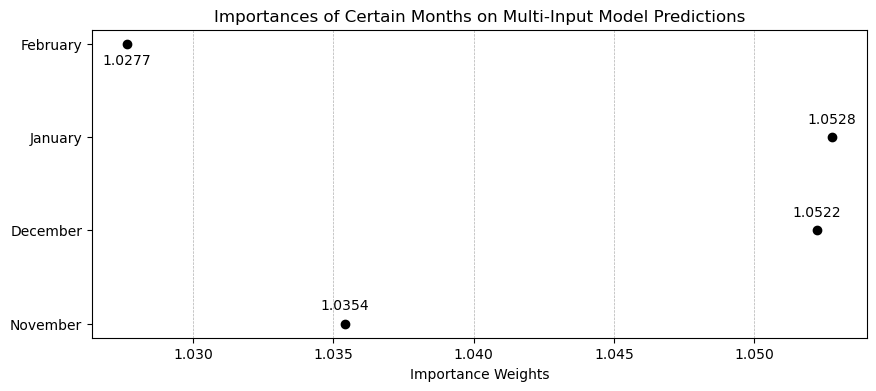

In [38]:
import matplotlib.pyplot as plt

# Sample data
categories = ['November', 'December', 'January', 'February']
values = [1.0354055166244507, 1.052240252494812, 1.052765965461731, 1.0276517868041992]

# Creating the dot plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(values, categories, color='black')
ax.set_xlabel('Importance Weights')
ax.set_title('Importances of Certain Months on Multi-Input Model Predictions')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='x')

# Adding value labels with conditional positioning
for i, txt in enumerate(values):
    if categories[i] == 'February':
        ax.annotate(f'{txt:.4f}', (values[i], categories[i]), textcoords="offset points", xytext=(0,-15), ha='center')
    else:
        ax.annotate(f'{txt:.4f}', (values[i], categories[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()
